In [1]:
import gym
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from collections import deque

In [2]:
problem = 'LunarLanderContinuous-v2'
#problem = 'Pendulum-v0'
env = gym.make(problem)


num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print(num_states, num_actions, upper_bound, lower_bound)

8 2 1.0 -1.0


In [3]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
### This shit just doesn't work with deque
### So it needs to be this way

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
    
    @tf.function
    def update(self, states, actions, rewards, n_states):
        with tf.GradientTape() as tape:
            target_actions = target_actor(n_states, training=True)
            y = rewards + gamma * target_critic([n_states, target_actions], training=True)
            critic_value = critic_model([states, actions], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))

        with tf.GradientTape() as tape:
            acts = actor_model(states, training=True)
            critic_value = critic_model([states, acts], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))
        
    def learn(self):
        record_range = min(self.buffer_counter, self.buffer_capacity)

        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)

In [5]:
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [6]:
def actor():
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(2, activation="tanh", kernel_initializer=last_init)(out)

    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def critic():
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [7]:
def choose_action(state, noise_obj):
    state = tf.expand_dims(state, 0)
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_obj()
    sampled_actions = sampled_actions.numpy() + noise

    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [8]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = actor()
critic_model = critic()

target_actor = actor()
target_critic = critic()

target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

critic_lr = 0.001
actor_lr = 0.0005

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 2000

gamma = 0.99

tau = 0.005

memory = Buffer(50000, 64)

In [9]:
score_hist = []
avg_hist = []

for i in range(total_episodes):
    state = env.reset()
    score = 0
    
    while True:
        
        state = tf.convert_to_tensor(state)
        
        action = choose_action(state, ou_noise)[0]
        
        n_state, reward, done, _ = env.step(action)
        
        memory.record((state, action, reward, n_state))
        
        score += reward
        
        memory.learn()
        
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        
        if done:
            break
        
        state = n_state
    
    score_hist.append(score)
    
    avg = np.mean(score_hist[-40:])
    
    print('Episode', i, 'Avg score', avg)
    avg_hist.append(avg)

Episode 0 Avg score -774.6085627960002
Episode 1 Avg score -541.8464994846487
Episode 2 Avg score -637.6841913049574
Episode 3 Avg score -570.9279634648976
Episode 4 Avg score -482.13014001000556
Episode 5 Avg score -430.7265722760282
Episode 6 Avg score -385.44643386998985
Episode 7 Avg score -360.93309199110377
Episode 8 Avg score -352.2749794001158
Episode 9 Avg score -416.56197433189953
Episode 10 Avg score -429.37214481151005
Episode 11 Avg score -449.03602262868884
Episode 12 Avg score -466.0491756376043
Episode 13 Avg score -477.6558481429828
Episode 14 Avg score -485.2398114805321
Episode 15 Avg score -487.64140362400144
Episode 16 Avg score -494.5374639376838
Episode 17 Avg score -510.06250497852153
Episode 18 Avg score -505.78811062149543
Episode 19 Avg score -503.26252760917225
Episode 20 Avg score -504.81661848576414
Episode 21 Avg score -500.387913839081
Episode 22 Avg score -498.2268796101144
Episode 23 Avg score -502.65598211099274
Episode 24 Avg score -498.2052642210286

Episode 201 Avg score -300.5543135979981
Episode 202 Avg score -295.0654909827398
Episode 203 Avg score -294.6937031116061
Episode 204 Avg score -293.05294215735876
Episode 205 Avg score -297.3992824467041
Episode 206 Avg score -296.0357807693494
Episode 207 Avg score -300.1510765662773
Episode 208 Avg score -298.2422195068236
Episode 209 Avg score -295.81099152843456
Episode 210 Avg score -304.16702355427094
Episode 211 Avg score -306.61449274712453
Episode 212 Avg score -311.762133267789
Episode 213 Avg score -310.4275299769341
Episode 214 Avg score -310.48805282890964
Episode 215 Avg score -310.625236449172
Episode 216 Avg score -324.7439816738273
Episode 217 Avg score -325.89277134747306
Episode 218 Avg score -323.1016359095603
Episode 219 Avg score -318.0244135770032
Episode 220 Avg score -312.27262758834524
Episode 221 Avg score -307.97210679353464
Episode 222 Avg score -316.1807744761053
Episode 223 Avg score -307.4447040204558
Episode 224 Avg score -304.6798569734948
Episode 22

Episode 399 Avg score -268.65169849826816
Episode 400 Avg score -265.77965660977605
Episode 401 Avg score -268.6282872788023
Episode 402 Avg score -270.79313694854187
Episode 403 Avg score -268.63603707574157
Episode 404 Avg score -267.760907193746
Episode 405 Avg score -272.76246779578366
Episode 406 Avg score -273.5766638397289
Episode 407 Avg score -274.00077574517974
Episode 408 Avg score -277.5759039206051
Episode 409 Avg score -276.42032811131696
Episode 410 Avg score -272.09826855704625
Episode 411 Avg score -271.66731674345846
Episode 412 Avg score -274.08119167022625
Episode 413 Avg score -283.4915900462539
Episode 414 Avg score -277.88872463041287
Episode 415 Avg score -268.5618873479633
Episode 416 Avg score -268.4889960829597
Episode 417 Avg score -266.70076183521826
Episode 418 Avg score -255.77176321609832
Episode 419 Avg score -254.73084267150676
Episode 420 Avg score -254.11498211350727
Episode 421 Avg score -250.40974024649412
Episode 422 Avg score -247.45645475456618


Episode 597 Avg score -339.0315560742622
Episode 598 Avg score -348.7125606172679
Episode 599 Avg score -352.5694033535833
Episode 600 Avg score -360.3911698724662
Episode 601 Avg score -366.2867515790195
Episode 602 Avg score -379.7793420099339
Episode 603 Avg score -394.34688121774167
Episode 604 Avg score -406.85454130217397
Episode 605 Avg score -416.1290191389311
Episode 606 Avg score -427.2862339692638
Episode 607 Avg score -436.23561765931635
Episode 608 Avg score -447.1251921519441
Episode 609 Avg score -452.0500200215981
Episode 610 Avg score -463.6836342166968
Episode 611 Avg score -471.9916020889817
Episode 612 Avg score -469.79956394804066
Episode 613 Avg score -474.5879419812489
Episode 614 Avg score -477.69266688092665
Episode 615 Avg score -478.6679630830775
Episode 616 Avg score -481.20367057290724
Episode 617 Avg score -481.13363267993554
Episode 618 Avg score -481.06055117511715
Episode 619 Avg score -480.3737335573305
Episode 620 Avg score -482.5930321284146
Episode 

Episode 795 Avg score -191.76965612058706
Episode 796 Avg score -184.79547895730488
Episode 797 Avg score -179.78828700972858
Episode 798 Avg score -177.14247481021863
Episode 799 Avg score -176.7112261093809
Episode 800 Avg score -172.80758693562805
Episode 801 Avg score -171.7010264469599
Episode 802 Avg score -172.4167371208617
Episode 803 Avg score -170.96475146686103
Episode 804 Avg score -168.8144019372488
Episode 805 Avg score -162.55858124418705
Episode 806 Avg score -154.98836009166763
Episode 807 Avg score -159.80226063068207
Episode 808 Avg score -152.43186736632006
Episode 809 Avg score -150.71338737347597
Episode 810 Avg score -150.2845202509646
Episode 811 Avg score -150.159066796509
Episode 812 Avg score -144.66785500464098
Episode 813 Avg score -144.2556020848947
Episode 814 Avg score -138.93405289970892
Episode 815 Avg score -133.6047648198957
Episode 816 Avg score -130.49835431673992
Episode 817 Avg score -129.52408937109377
Episode 818 Avg score -127.6214395722362
Ep

Episode 991 Avg score -117.9538116428217
Episode 992 Avg score -115.12653197206869
Episode 993 Avg score -115.91352924244241
Episode 994 Avg score -121.84092162570087
Episode 995 Avg score -121.28655769955772
Episode 996 Avg score -114.76769648359269
Episode 997 Avg score -116.19644279501726
Episode 998 Avg score -114.03990706312395
Episode 999 Avg score -113.2791847785199
Episode 1000 Avg score -107.01449070297444
Episode 1001 Avg score -103.31337676768271
Episode 1002 Avg score -103.27840844655103
Episode 1003 Avg score -103.41770293402287
Episode 1004 Avg score -98.29594379899561
Episode 1005 Avg score -98.42683134335368
Episode 1006 Avg score -98.07029832579985
Episode 1007 Avg score -102.3015809893807
Episode 1008 Avg score -99.84196546414276
Episode 1009 Avg score -97.70161779931156
Episode 1010 Avg score -99.59285836965394
Episode 1011 Avg score -98.46508110854366
Episode 1012 Avg score -98.40044950477827
Episode 1013 Avg score -95.87876798856094
Episode 1014 Avg score -92.74705

Episode 1184 Avg score -251.16325363622036
Episode 1185 Avg score -258.43750703093247
Episode 1186 Avg score -254.6007370405993
Episode 1187 Avg score -247.36482858946056
Episode 1188 Avg score -241.33096057624545
Episode 1189 Avg score -236.69146897470415
Episode 1190 Avg score -235.8415113343367
Episode 1191 Avg score -233.34473679081776
Episode 1192 Avg score -230.72939829581023
Episode 1193 Avg score -227.80262200489656
Episode 1194 Avg score -219.75005274493023
Episode 1195 Avg score -221.65169743149926
Episode 1196 Avg score -221.8882251812911
Episode 1197 Avg score -221.1920182256199
Episode 1198 Avg score -221.47991948105147
Episode 1199 Avg score -225.32407796288635
Episode 1200 Avg score -225.16085511353532
Episode 1201 Avg score -222.05686777270085
Episode 1202 Avg score -214.4878502110608
Episode 1203 Avg score -209.84820111025266
Episode 1204 Avg score -202.21907421222642
Episode 1205 Avg score -199.89031226465687
Episode 1206 Avg score -201.37487469350702
Episode 1207 Avg

Episode 1377 Avg score -220.8119991851739
Episode 1378 Avg score -222.18046106716665
Episode 1379 Avg score -222.74386683137732
Episode 1380 Avg score -219.01261793300628
Episode 1381 Avg score -215.71470198323536
Episode 1382 Avg score -202.92995347871567
Episode 1383 Avg score -195.51803548945796
Episode 1384 Avg score -192.7903710080064
Episode 1385 Avg score -187.08076023974618
Episode 1386 Avg score -179.6643926424304
Episode 1387 Avg score -171.1273594719491
Episode 1388 Avg score -165.12948995280266
Episode 1389 Avg score -165.29528870649816
Episode 1390 Avg score -159.29655345940517
Episode 1391 Avg score -150.71080981535619
Episode 1392 Avg score -144.3343725425899
Episode 1393 Avg score -133.13760931532516
Episode 1394 Avg score -123.44877208950489
Episode 1395 Avg score -116.21300585304702
Episode 1396 Avg score -109.18473399860561
Episode 1397 Avg score -100.12046565146923
Episode 1398 Avg score -97.19410957054056
Episode 1399 Avg score -92.26331540867578
Episode 1400 Avg s

Episode 1571 Avg score -1227.1916252618212
Episode 1572 Avg score -1206.951141029885
Episode 1573 Avg score -1197.6422838858591
Episode 1574 Avg score -1182.8315107858862
Episode 1575 Avg score -1152.6371090911257
Episode 1576 Avg score -1123.4137944638483
Episode 1577 Avg score -1086.9565950296071
Episode 1578 Avg score -1056.747495596845
Episode 1579 Avg score -1019.5845457542684
Episode 1580 Avg score -1012.5980932183359
Episode 1581 Avg score -996.291561729758
Episode 1582 Avg score -977.4816354992388
Episode 1583 Avg score -928.2344359054762
Episode 1584 Avg score -904.385709931312
Episode 1585 Avg score -867.658050203356
Episode 1586 Avg score -838.0611478661085
Episode 1587 Avg score -845.3011914558134
Episode 1588 Avg score -864.9489935233548
Episode 1589 Avg score -868.9908888884383
Episode 1590 Avg score -885.7074726184828
Episode 1591 Avg score -974.85115928364
Episode 1592 Avg score -980.9771735220049
Episode 1593 Avg score -1116.47116473113
Episode 1594 Avg score -1179.273

Episode 1764 Avg score -280.04574357584545
Episode 1765 Avg score -285.37847821857457
Episode 1766 Avg score -289.3193669206334
Episode 1767 Avg score -288.4183569279874
Episode 1768 Avg score -291.9524041709623
Episode 1769 Avg score -296.5618843431391
Episode 1770 Avg score -298.6343365972516
Episode 1771 Avg score -301.08129974489214
Episode 1772 Avg score -300.5843940569481
Episode 1773 Avg score -306.91134333267183
Episode 1774 Avg score -308.2673049191608
Episode 1775 Avg score -313.25986611678184
Episode 1776 Avg score -316.65395819522007
Episode 1777 Avg score -318.2651313710499
Episode 1778 Avg score -322.5708772185294
Episode 1779 Avg score -328.406687398059
Episode 1780 Avg score -331.06318924962454
Episode 1781 Avg score -333.9222484783362
Episode 1782 Avg score -326.2107229847933
Episode 1783 Avg score -329.48680710266524
Episode 1784 Avg score -325.164724283441
Episode 1785 Avg score -325.60299133674926
Episode 1786 Avg score -320.49418780554544
Episode 1787 Avg score -31

Episode 1957 Avg score -138.1769739003096
Episode 1958 Avg score -138.92250861040378
Episode 1959 Avg score -138.3761616125696
Episode 1960 Avg score -139.04023670050606
Episode 1961 Avg score -139.18113787524172
Episode 1962 Avg score -138.82977100969785
Episode 1963 Avg score -138.8565553248499
Episode 1964 Avg score -137.35251278057643
Episode 1965 Avg score -135.4943898366568
Episode 1966 Avg score -131.1450586059308
Episode 1967 Avg score -131.90553112895068
Episode 1968 Avg score -131.0140101545167
Episode 1969 Avg score -131.64574431403298
Episode 1970 Avg score -130.1155107195463
Episode 1971 Avg score -130.38480783891495
Episode 1972 Avg score -130.5517865317845
Episode 1973 Avg score -128.05767385735533
Episode 1974 Avg score -129.08993843584298
Episode 1975 Avg score -128.88746699587236
Episode 1976 Avg score -132.7004661390792
Episode 1977 Avg score -131.71106329095937
Episode 1978 Avg score -130.97024065248365
Episode 1979 Avg score -131.72900184976461
Episode 1980 Avg sco

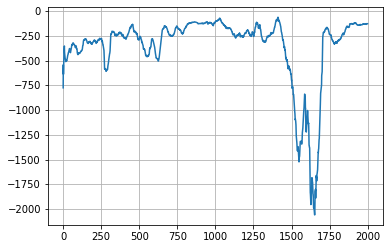

In [10]:
plt.plot(avg_hist)
plt.grid()